# Project: Masters thesis - structuring optimal portfolio based on selected asset classes
**Abstract:** Creating multiple asset allocation strategies based on:  
1. manually selected securities 
2. bond & multi-asset ETFs 
3. Single multi-asset ETF's portfolios 
4. SP500
And then determining best strategies based on total returs and time of entry/exit.
**Data:** Stocks & Securities data  
**Source:** https://stooq.com/


## 1. Setting-up project environment

### 1.1 Importing packages & data

In [1]:
from urllib.request import urlretrieve
from datetime import datetime
import pandas as pd
import mplfinance as mpl #https://pypi.org/project/mplfinance/
import os
import string
import re
import numpy as np
import matplotlib.pyplot as plt 

#Python portfolio optimizer
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

from IPython.display import display, HTML
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100



Useful:  
* dir() #list of variables  
* %whos #list of objects in environment  

### Research and links:  

* Markdown : https://www.markdownguide.org/basic-syntax/
* Sortino ratio: https://www.investopedia.com/terms/s/sortinoratio.asp
* Sharpe ratio: http://web.stanford.edu/~wfsharpe/art/sr/sr.htm

Libraries to explore:  
* https://www.activestate.com/blog/top-10-python-packages-for-finance-and-financial-modeling/
* https://quantlib-python-docs.readthedocs.io/en/latest/
* https://github.com/quandl/quandl-python
* https://github.com/quantopian/pyfolio
* https://gbeced.github.io/pyalgotrade/docs/v0.20/html/tutorial.html

Stooq data:
* https://www.quantstart.com/articles/an-introduction-to-stooq-pricing-data/

Portfolio analysis:
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-analysis-in-python 
* https://app.datacamp.com/learn/courses/quantitative-risk-management-in-python
* https://app.datacamp.com/learn/courses/introduction-to-portfolio-risk-management-in-python
* https://app.datacamp.com/learn/courses/bond-valuation-and-analysis-in-python


### 1.2 Establishing portfolio parameters

In [2]:
# PARAMETERS for calculations
portfolio_stocks = ['AAPLUS','MSFTUS','AMZNUS','NVDAUS'] # securities chosen  for your porfolio "SPX","V80ADE","WIG","PKO"
portfolio_weights = np.array([0.25, 0.25, 0.25 ,0.25]) # weights for your securities in portfolio. Number of weights must match number of securities
capital = 100000 #starting capital
rfr = 0.0 # risk-free-rate
target_return = 0.0 # target return for Sortino ratio

In [3]:
ticker_list = ['WIG','WIG20','^SPX','V80A.DE','^TBSP','EURPLN','USDPLN','BTC.V','XAGPLN','XAUPLN','HUG','KGH','PCF','PKO','PZU',
              'AAPL.US', 'MSFT.US', 'AMZN.US', 'GOOGL.US', 'GOOG.US', 'TSLA.US', 'NVDA.US', 'META.US', 'BRK-B.US', 'UNH.US']

# WIG - index WIG
# WIG20 - top 20 companies of WIG index
# ^SPX - S&P500 index
# V80A.DE - Multi-Aasset ETF Vanguard Life Strategy 80/20 ACC EUR denominated (Xetra exchange; IKE DM BOS)
# ^TBSP - Polish treasury bonds index
# EURPLN - eur/pln exchange rate
# USDPLN - usd/pln exchange rate
# BTC.V - bitcoin price
# XAGPLN - silver (ozt - trojan ounce - 31,1034768 g)
# XAUPLN - gold (ozt - trojan ounce - 31,1034768 g)
# HUG - Huuuge Inc (game developer; MBank portfolio)
# KGH - KGHM (raw materials extractor - copper / silver ; MBank portfolio)
# PCF - PFC Group (game developer; MBank portfolio)
# PKO - PKO BP (polish bank (state owned); MBank portfolio)
# PZU - PZU (polish insurer (state owned); MBank portfolio)

#Stooq notes:  
#Indices are prefixed by ^ e.g. ^DJI (Dow Jones Industrial), ^UK100 (FTSE100)  
#US stocks are suffixed by .US e.g. AAPL.US, MSFT.US, TSLA.US  
#Cryptocurrencies are suffixed by .V e.g. BTC.V (BitCoin)  
#UK stocks are suffixed by .UK e.g. AV.UK (Aviva)  
#Price/Earnings are suffixed by _PE.US e.g. AAPL_PE.US  


### 1.3 Downloading portfolio data from stooq.com

In [4]:
#Creating data folder
data_folder="data/"

os.makedirs(data_folder, exist_ok=True)

In [5]:
#Downloading data for each security
for ticker in ticker_list:
    interval = 'd'
    url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
    csv_file = data_folder + ticker + '.csv'
    urlretrieve(url, csv_file)

In [6]:
# Inspect downloaded files
path, dirs, files = next(os.walk("./data"))
print(path)
print(dirs)
print(files)

./data
[]
['AAPL.US.csv', 'AMZN.US.csv', 'BRK-B.US.csv', 'BTC.V.csv', 'EURPLN.csv', 'GOOG.US.csv', 'GOOGL.US.csv', 'HUG.csv', 'KGH.csv', 'META.US.csv', 'MSFT.US.csv', 'NVDA.US.csv', 'PCF.csv', 'PKO.csv', 'PZU.csv', 'TSLA.US.csv', 'UNH.US.csv', 'USDPLN.csv', 'V80A.DE.csv', 'WIG.csv', 'WIG20.csv', 'XAGPLN.csv', 'XAUPLN.csv', '^SPX.csv', '^TBSP.csv']


### 1.4 Creating portfolio data dictionary

In [7]:
# Creating list of dataframe names out of tickers list 
# Deleting special characters
files_clean = []
pattern = r'[' + string.punctuation + ']'
for file in ticker_list:
    sample_str = re.sub(pattern, '', file)
    files_clean.append(sample_str)
    
# Sorting to match files order
files_clean.sort()

# Adjusting order of list to match files order - manual
element = 'SPX'
del files_clean[files_clean.index(element)]
files_clean.append(element)
element = 'TBSP'
del files_clean[files_clean.index(element)]
files_clean.append(element)

#displaying list
files_clean


['AAPLUS',
 'AMZNUS',
 'BRKBUS',
 'BTCV',
 'EURPLN',
 'GOOGLUS',
 'GOOGUS',
 'HUG',
 'KGH',
 'METAUS',
 'MSFTUS',
 'NVDAUS',
 'PCF',
 'PKO',
 'PZU',
 'TSLAUS',
 'UNHUS',
 'USDPLN',
 'V80ADE',
 'WIG',
 'WIG20',
 'XAGPLN',
 'XAUPLN',
 'SPX',
 'TBSP']

In [8]:
# Create a dictionary containing security name and corresponding dataframe
securities = dict()
for i, row in enumerate(files):
    print(row)
    dfName = files_clean[i]
    dfNew = pd.read_csv("./data/"+row, index_col='Date', parse_dates=['Date'],
                date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
    securities[dfName] = dfNew

#Check key names
securities.keys()

AAPL.US.csv
AMZN.US.csv
BRK-B.US.csv
BTC.V.csv
EURPLN.csv
GOOG.US.csv
GOOGL.US.csv
HUG.csv
KGH.csv
META.US.csv
MSFT.US.csv
NVDA.US.csv
PCF.csv
PKO.csv
PZU.csv
TSLA.US.csv
UNH.US.csv
USDPLN.csv
V80A.DE.csv
WIG.csv
WIG20.csv
XAGPLN.csv
XAUPLN.csv
^SPX.csv
^TBSP.csv


dict_keys(['AAPLUS', 'AMZNUS', 'BRKBUS', 'BTCV', 'EURPLN', 'GOOGLUS', 'GOOGUS', 'HUG', 'KGH', 'METAUS', 'MSFTUS', 'NVDAUS', 'PCF', 'PKO', 'PZU', 'TSLAUS', 'UNHUS', 'USDPLN', 'V80ADE', 'WIG', 'WIG20', 'XAGPLN', 'XAUPLN', 'SPX', 'TBSP'])

In [9]:
# Data dictionary check
# Adding daily return and cumulative return to chosen security
securities["SPX"]["daily_return"]=securities["SPX"]["Close"].pct_change()
securities["SPX"]["cum_return"]=(securities["SPX"]["daily_return"]+1).cumprod()
securities["SPX"]

,Open,High,Low,Close,Volume,daily_return,cum_return
Date,,,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN,NaN,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN,0.000000,1.000000
1789-07-01,0.50,0.50,0.50,0.50,NaN,-0.019608,0.980392
1789-08-01,0.50,0.51,0.50,0.51,NaN,0.020000,1.000000
1789-09-01,0.51,0.51,0.50,0.51,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...
2022-12-13,4069.38,4100.96,3993.03,4019.65,3.099177e+09,0.007290,7881.666667
2022-12-14,4015.54,4053.76,3965.65,3995.32,2.606576e+09,-0.006053,7833.960784
2022-12-15,3958.37,3958.37,3879.45,3895.75,2.677418e+09,-0.024922,7638.725490


## 2. Exploaratory Data Analysis (EDA)

### 2.1 Preliminary graph analysis

AAPLUS


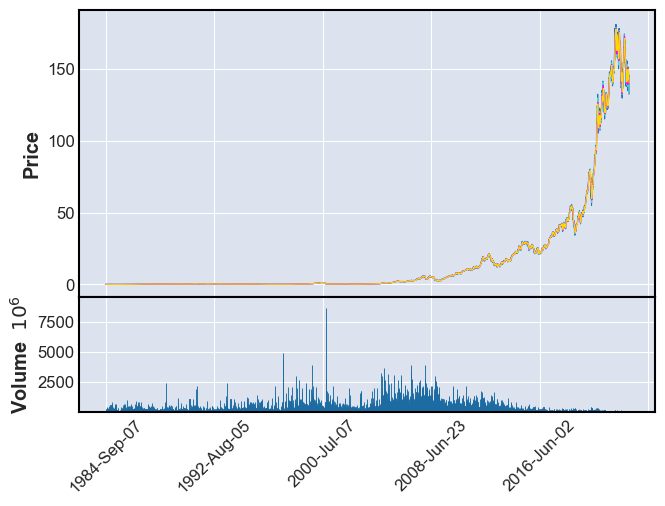

MSFTUS


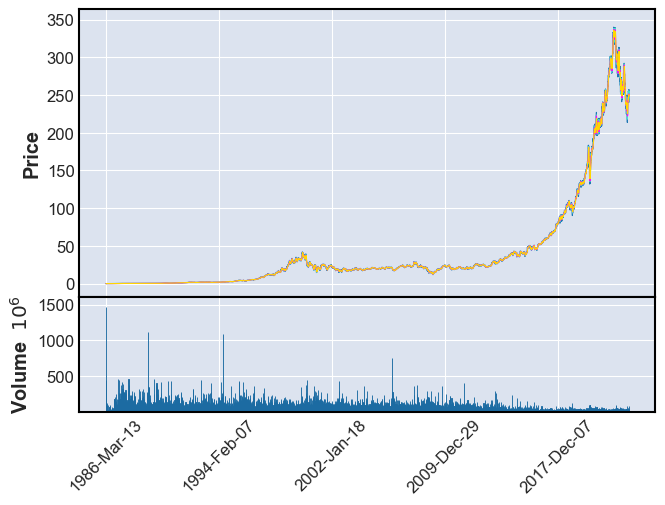

AMZNUS


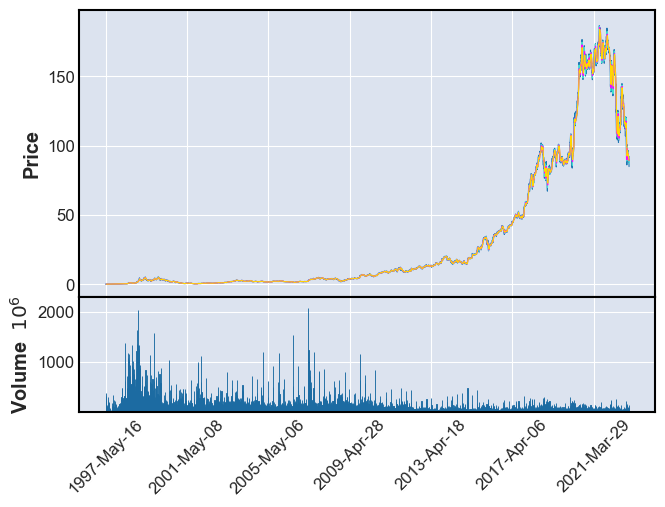

NVDAUS


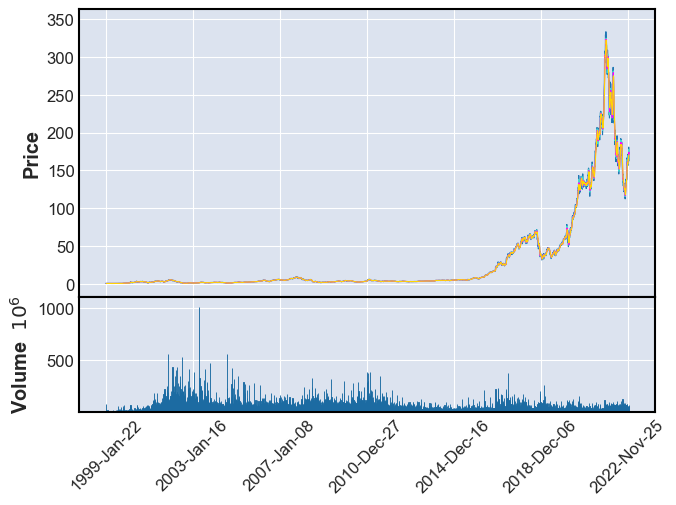

In [10]:
# Line graphs for chosen securities in portfollio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security], type='line', volume=True, mav=(3,6,9))

AAPLUS


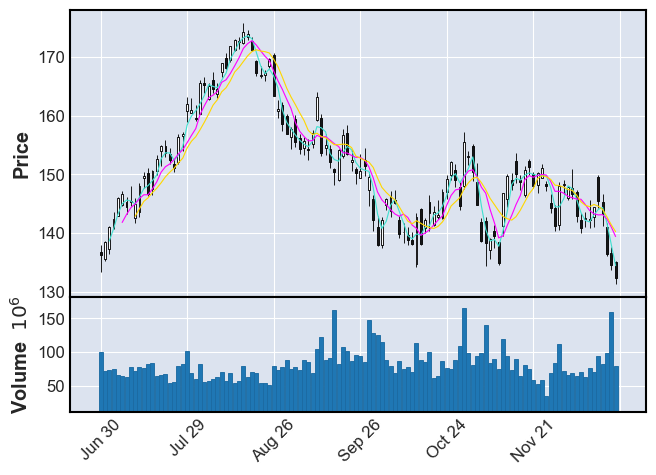

MSFTUS


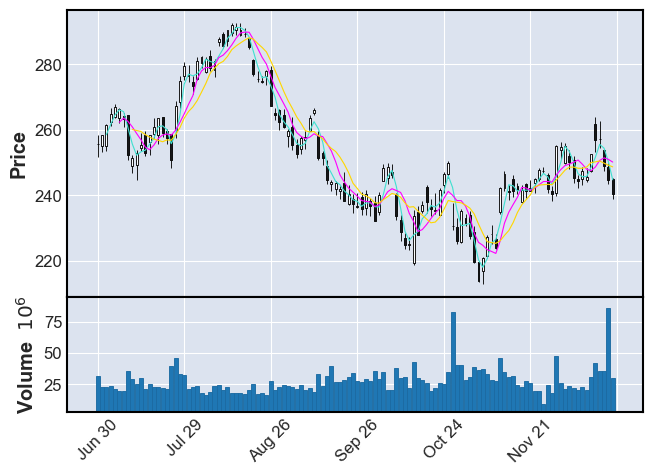

AMZNUS


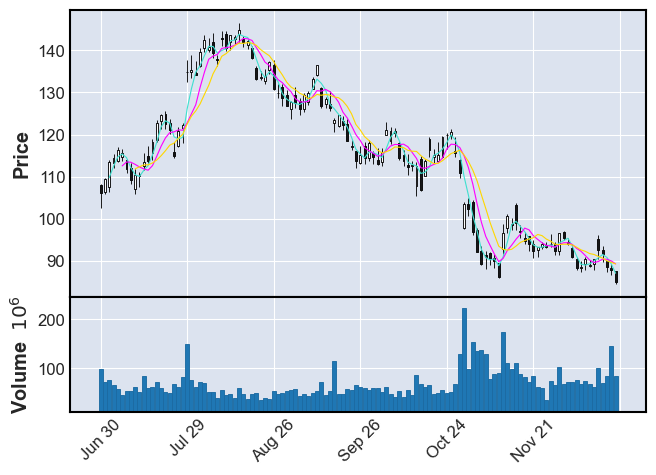

NVDAUS


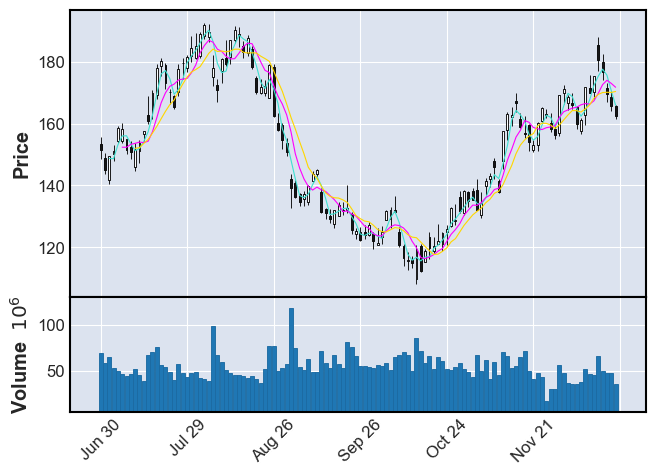

In [11]:
# Candle graphs for chosen securities in portfolio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security].tail(120), type='candle', volume=True, mav=(3,6,9))

### 2.2 Calculating portfolio statistics

In [12]:
#Creating portfolio

stocks = pd.DataFrame()
for item in portfolio_stocks:
    item = pd.Series(data=securities[item]["Close"], name=item)
    stocks = pd.merge(stocks, item, how='outer', left_index=True, right_index=True)
    

#Leaving only non-missing values for all observations (TBU : should we update missing values with last closing price?)
stocks = stocks[~stocks.isnull().any(axis=1)]

In [13]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2022-12-13,145.470000,256.9200,92.4900,180.720000
2022-12-14,143.210000,257.2200,91.5800,176.740000
2022-12-15,136.500000,249.0100,88.4500,169.520000


In [14]:
# Calculate daily returns from prices
stocks_dailyReturns = stocks.pct_change()

stocks_meanDailyReturns = stocks_dailyReturns.mean()
portfolio_return = np.sum(stocks_meanDailyReturns*portfolio_weights)
print('Average historic daily portfolio return: ', str(np.round(portfolio_return, 4) * 100) + '%')

Average historic daily portfolio return:  0.12%


In [15]:
#Calculate daily portfolio returns
portfolio_dailyReturns = pd.DataFrame()
portfolio_dailyReturns["Portfolio"]= stocks_dailyReturns.dot(portfolio_weights)
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2022-12-13,0.019074
2022-12-14,-0.011558
2022-12-15,-0.038450


In [16]:
# Compound the percentage returns over time 
stocks_dailyCumRet=(1+stocks_dailyReturns).cumprod()
display(HTML(stocks_dailyCumRet.tail().to_html()))

portfolio_dailyCumRet=(1+portfolio_dailyReturns).cumprod()
display(portfolio_dailyCumRet.tail())

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
2022-12-13,493.217288,9.327858,30.078049,480.265326
2022-12-14,485.554738,9.338750,29.782114,469.688433
2022-12-15,462.804425,9.040674,28.764228,450.501207
2022-12-16,456.057313,8.883830,28.572358,440.376091
2022-12-19,448.801625,8.729891,27.616260,431.951782


,Portfolio
Date,
2022-12-13,331.318288
2022-12-14,327.489069
2022-12-15,314.897016
2022-12-16,310.089080
2022-12-19,303.435361


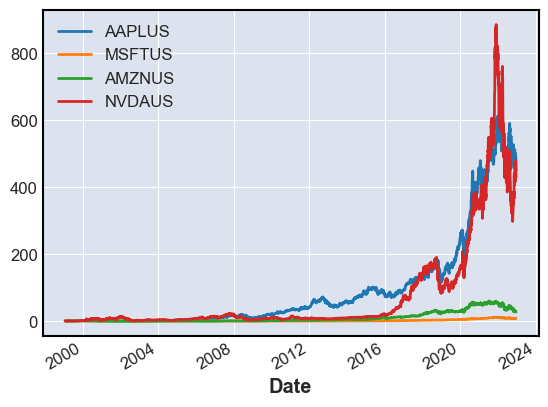

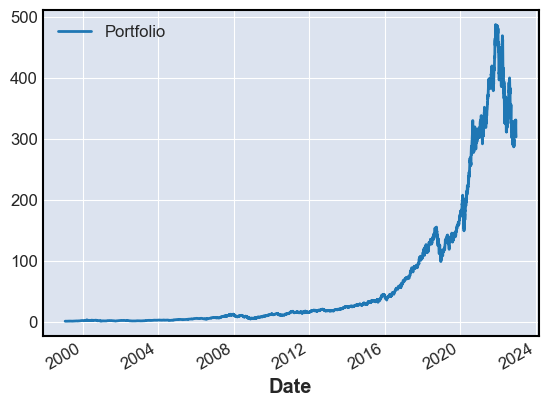

In [17]:
# Plot your cumulative return 
stocks_dailyCumRet.plot()
plt.show()
portfolio_dailyCumRet.plot()
plt.show()

In [18]:
#  The multiplication with 250 is to account for 250 trading days in a year.
stocks_covMatrix = stocks_dailyReturns.cov() * 250
display(stocks_covMatrix)
# Calculate the variance with the formula
portfolio_variance = np.dot(portfolio_weights.T, np.dot(stocks_covMatrix, portfolio_weights))


# Just converting the variance float into a percentage
print('Portfolio daily returns variance: ', str(np.round(portfolio_variance, 4) * 100) + '%')
print('Portfolio daily returns standard deviation: ', str(np.round(np.sqrt(portfolio_variance),4) * 100) + '%')

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.165580,0.059468,0.078416,0.100481
MSFTUS,0.059468,0.096277,0.070032,0.086407
AMZNUS,0.078416,0.070032,0.282285,0.105698
NVDAUS,0.100481,0.086407,0.105698,0.367289


Portfolio daily returns variance:  11.95%
Portfolio daily returns standard deviation:  34.57%


Good job! The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. The mean historic return of this particular portfolio is actually close to zero. With an average standard deviation of roughly 16%, this means you're getting a bad deal here! Now that you've learned how to calculate basic risk and return of a portfolio, you're ready to dive deeper into the world of portfolio analysis in the next chapters.

In [19]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.294941,27.5433,3.0750,0.376292
1999-01-25,0.299896,28.5321,2.8095,0.415293
1999-01-26,0.307990,30.2336,2.8775,0.383147
1999-01-27,0.305329,29.7164,3.1405,0.383147
1999-01-28,0.311201,30.6665,3.0720,0.380859
...,...,...,...,...
2022-12-13,145.470000,256.9200,92.4900,180.720000
2022-12-14,143.210000,257.2200,91.5800,176.740000
2022-12-15,136.500000,249.0100,88.4500,169.520000


In [20]:
# doesn't account for weights in portfolio yet
years=(stocks.index[-1]-stocks.index[0])/ np.timedelta64(1, 'Y')

stocks_totalReturns = pd.DataFrame()

def total_return(data):
    return ((data[-1]-data[0])/data[0])
    
stocks_totalReturns["total_return"] = stocks.apply(total_return)
stocks_totalReturns["annualized_return"] = (((1+stocks_totalReturns["total_return"])**(1/years))-1)
print(stocks.index[0],' - portfolio start date')
print(stocks.index[-1],' - portfolio end date')
print(years,'years')
display(stocks_totalReturns)

1999-01-22 00:00:00  - portfolio start date
2022-12-19 00:00:00  - portfolio end date
23.90740398502365 years


,total_return,annualized_return
AAPLUS,447.801625,0.291012
MSFTUS,7.729891,0.094865
AMZNUS,26.616260,0.148897
NVDAUS,430.951782,0.288947


In [21]:
years

23.90740398502365

In [22]:
# Calculate annualized volatility from the standard deviation
# 250 accounts for 250 trading days in a year
stocks_volatility = stocks_dailyReturns.std() * np.sqrt(250)
display(stocks_volatility)

AAPLUS    0.406916
MSFTUS    0.310285
AMZNUS    0.531305
NVDAUS    0.606044
dtype: float64

In [23]:
# Calculate the Sharpe ratio 
stocks_sharpeRatio = ((stocks_totalReturns["annualized_return"] - rfr) / stocks_volatility)
display(stocks_sharpeRatio)

AAPLUS    0.715165
MSFTUS    0.305735
AMZNUS    0.280248
NVDAUS    0.476776
dtype: float64

In [24]:
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008355
1999-01-27,0.016413
1999-01-28,0.005855
...,...
2022-12-13,0.019074
2022-12-14,-0.011558
2022-12-15,-0.038450


In [25]:
# ZASTANOW SIE CZY TO JEST OK
portfolio = pd.DataFrame()
portfolio["Portfolio"] = pd.DataFrame(data=np.dot(stocks, portfolio_weights))
portfolio.index=stocks.index
portfolio

,Portfolio
Date,
1999-01-22,7.822383
1999-01-25,8.014197
1999-01-26,8.450559
1999-01-27,8.386344
1999-01-28,8.607640
...,...
2022-12-13,168.900000
2022-12-14,167.187500
2022-12-15,160.870000


In [26]:
# Portfolio statistics
portfolio_totalReturns = pd.DataFrame()
portfolio_totalReturns["total_return"] = portfolio.apply(total_return)
portfolio_totalReturns["annualized_return"] = (((1+portfolio_totalReturns["total_return"])**(1/years))-1)
display(portfolio_totalReturns)

,total_return,annualized_return
Portfolio,18.823882,0.133076


In [27]:
print(portfolio_dailyReturns.mean())

Portfolio    0.00119
dtype: float64


In [28]:
portfolio_variance = portfolio_dailyReturns.std()
display(portfolio_variance)

Portfolio    0.021866
dtype: float64

In [29]:
portfolio_volatility = portfolio_dailyReturns.std() * np.sqrt(250)
display(portfolio_volatility)

Portfolio    0.345727
dtype: float64

In [30]:
portfolio_sharpeRatio = ((portfolio_totalReturns["annualized_return"] - rfr) / portfolio_volatility)
display(portfolio_sharpeRatio)

Portfolio    0.384915
dtype: float64

In [31]:
stocks_totalReturns["mean_dailyReturn"]=stocks_dailyReturns.mean()*100
stocks_totalReturns["std_dailyReturn"]=stocks_dailyReturns.std()*100
stocks_totalReturns["skew_dailyReturn"]=stocks_dailyReturns.skew()
stocks_totalReturns["kurtosis_dailyReturn"]=stocks_dailyReturns.kurtosis()

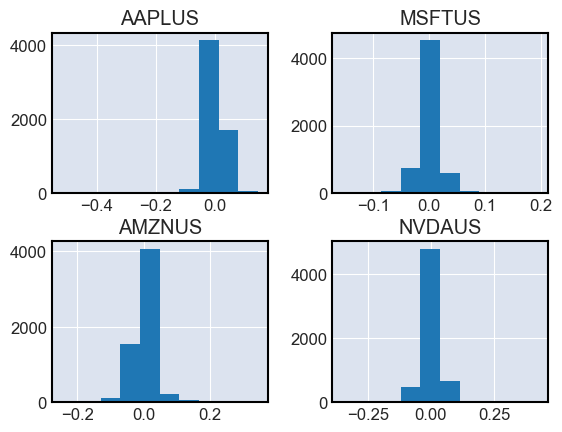

In [32]:
stocks_dailyReturns.hist()
plt.show()

In [33]:
stocks_totalReturns["sharpeRatio"]=stocks_sharpeRatio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio
AAPLUS,447.801625,0.291012,0.136001,2.573561,-1.267627,31.177405,0.715165
MSFTUS,7.729891,0.094865,0.055268,1.962415,0.252696,9.285751,0.305735
AMZNUS,26.616260,0.148897,0.110689,3.360265,1.075701,13.125544,0.280248
NVDAUS,430.951782,0.288947,0.173914,3.832957,0.602459,11.442530,0.476776


abs(skew) > 1 - Highly skewed distribution
abs(skew) > 0.5 - Moderatly skewed distribution
abs(skew) <= 0.5 - Approximately symmetric distribution (MSFT)

kurtosis = 3 - mesocurtic (normal distribution)
kurtosis < 3 - piatycurtic (tails are shorter and thinner, central peak is lower and broader)
kurtosis > 3 - leptocurtic (tails are longer and fatter, central peak is higher and sharper (fat tailed))

In [34]:
sortino_ratio = pd.Series(index=stocks.columns, dtype='float64')
for item in stocks.columns:
    downside_returns = stocks_dailyReturns[item].loc[stocks_dailyReturns[item] < target_return]
    expected_return = stocks_dailyReturns[item].mean()
    down_stdev = downside_returns.std()
    sortino_temp = (expected_return - rfr)/down_stdev
    sortino_ratio.update(pd.Series([sortino_temp], index=[item]))

In [35]:
stocks_totalReturns["sortinoRatio"]=sortino_ratio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio,sortinoRatio
AAPLUS,447.801625,0.291012,0.136001,2.573561,-1.267627,31.177405,0.715165,0.069061
MSFTUS,7.729891,0.094865,0.055268,1.962415,0.252696,9.285751,0.305735,0.038887
AMZNUS,26.616260,0.148897,0.110689,3.360265,1.075701,13.125544,0.280248,0.047407
NVDAUS,430.951782,0.288947,0.173914,3.832957,0.602459,11.442530,0.476776,0.066219


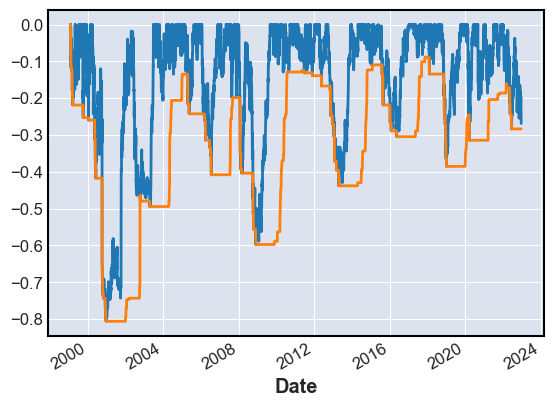

In [36]:
# Calculate the maximum value of returns using rolling().max()
roll_max = stocks['AAPLUS'].rolling(center=False, min_periods=1, window=250).max()
# Calculate daily draw-down from rolling max
daily_drawdown = stocks['AAPLUS']/roll_max - 1.0
# Calculate maximum daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=250).min()
# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show()

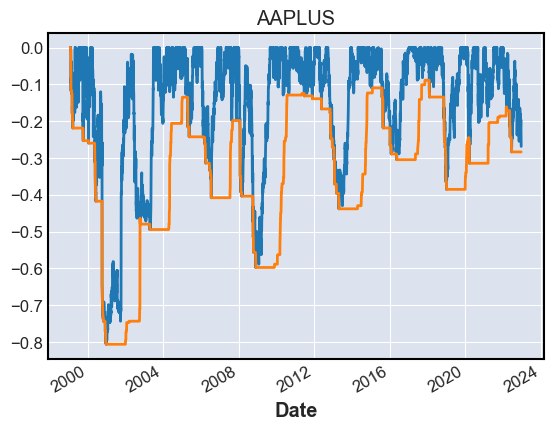

Biggest fall in analyzed period : - -0.8058


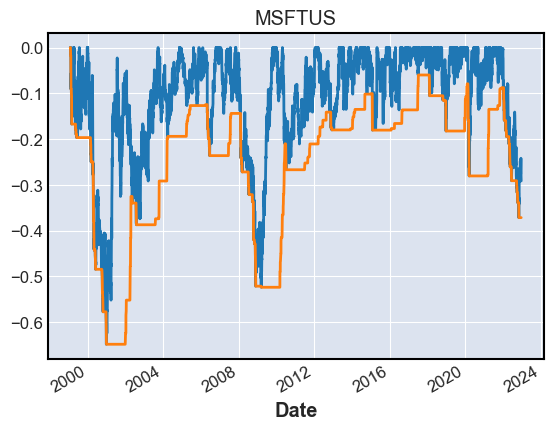

Biggest fall in analyzed period : - -0.648


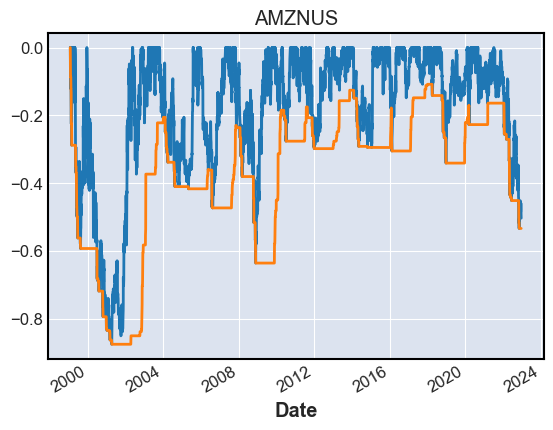

Biggest fall in analyzed period : - -0.8757


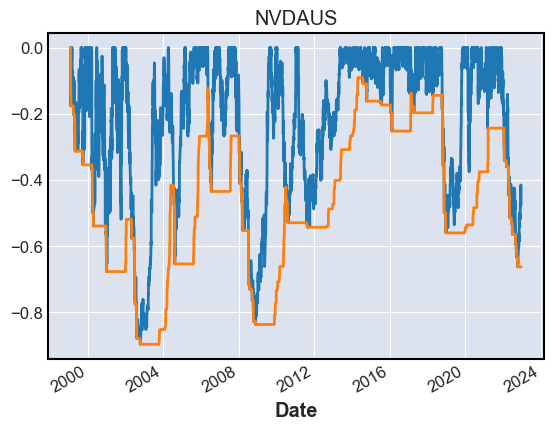

Biggest fall in analyzed period : - -0.8971


In [37]:
for stock in stocks:
    lookback_period = 250
    # Calculate the maximum value of returns using rolling().max()
    roll_max = stocks[stock].rolling(center = False, min_periods = 1, window = lookback_period).max()
    # Calculate daily draw-down from rolling max
    daily_drawdown = stocks[stock]/roll_max - 1.0
    # Calculate maximum daily draw-down
    max_daily_drawdown = daily_drawdown.rolling(center = False, min_periods = 1, window = lookback_period).min()
    daily_drawdown.plot()
    max_daily_drawdown.plot()
    plt.title(stock)
    plt.show()
    print('Biggest fall in analyzed period : -',round(min(max_daily_drawdown),4))


In [38]:
max_daily_drawdown.min()

-0.8970681502796363

In [39]:
daily_drawdown

Date
1999-01-22    0.000000
1999-01-25    0.000000
1999-01-26   -0.077406
1999-01-27   -0.077406
1999-01-28   -0.082915
                ...   
2022-12-13   -0.415456
2022-12-14   -0.428329
2022-12-15   -0.451683
2022-12-16   -0.464006
2022-12-19   -0.474260
Name: NVDAUS, Length: 6013, dtype: float64

In [40]:
# We want to calculate recovery time as well
# Our daily draw-down should be also time dependent i.e. from previous ATH

A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value". Let's see how our S&P500 returns relate to the returns of these factors. 

In [41]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(stocks)

In [42]:
# Calculate the covariance matrix S
Sigma = risk_models.sample_cov(stocks)

In [43]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, Sigma)
print (mu, Sigma)

AAPLUS    0.291707
MSFTUS    0.095074
AMZNUS    0.149233
NVDAUS    0.289637
dtype: float64           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166905  0.059944  0.079043  0.101285
MSFTUS  0.059944  0.097047  0.070592  0.087098
AMZNUS  0.079043  0.070592  0.284543  0.106543
NVDAUS  0.101285  0.087098  0.106543  0.370227


In [44]:
# Get the minimum risk portfolio for a target return 
weights = ef.efficient_return(0.25)
print (weights)

# Show portfolio performance 
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.6464755967952324), ('MSFTUS', 0.1845809501074948), ('AMZNUS', 0.0360561606598782), ('NVDAUS', 0.1328872924373945)])
Expected annual return: 25.0%
Annual volatility: 34.9%
Sharpe Ratio: 0.66


(0.25000000000000006, 0.3487056696064496, 0.6595820488367133)

In [45]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_ms = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe = ef_ms.max_sharpe()
cleaned_weights_maxsharpe = ef_ms.clean_weights()
print (raw_weights_maxsharpe, cleaned_weights_maxsharpe)
perf_max_sharpe=ef_ms.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.8073769423652123), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.1926230576347878)]) OrderedDict([('AAPLUS', 0.80738), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.19262)])
Expected annual return: 29.1%
Annual volatility: 39.2%
Sharpe Ratio: 0.69


In [46]:
# Calculate weights for the maximum Sharpe ratio portfolio
ef_mv = EfficientFrontier(mu, Sigma)
raw_weights_minvolatility = ef_mv.min_volatility()
cleaned_weights_minvolatility = ef_mv.clean_weights()
print (raw_weights_minvolatility, cleaned_weights_minvolatility)
perf_min_volatility=ef_mv.portfolio_performance(verbose=True)

OrderedDict([('AAPLUS', 0.2369457952572066), ('MSFTUS', 0.6979100796448376), ('AMZNUS', 0.0651441250979557), ('NVDAUS', 0.0)]) OrderedDict([('AAPLUS', 0.23695), ('MSFTUS', 0.69791), ('AMZNUS', 0.06514), ('NVDAUS', 0.0)])
Expected annual return: 14.5%
Annual volatility: 29.4%
Sharpe Ratio: 0.43


In [47]:
print(cleaned_weights_minvolatility,cleaned_weights_maxsharpe,perf_min_volatility,perf_max_sharpe, sep="\n")

OrderedDict([('AAPLUS', 0.23695), ('MSFTUS', 0.69791), ('AMZNUS', 0.06514), ('NVDAUS', 0.0)])
OrderedDict([('AAPLUS', 0.80738), ('MSFTUS', 0.0), ('AMZNUS', 0.0), ('NVDAUS', 0.19262)])
(0.14519349448006355, 0.2941637760616847, 0.4255911321107433)
(0.29130805838989055, 0.3924777015424857, 0.6912699939986818)


In [48]:
# Exponential weights for matrix
# Define exponentially weightedSigma and mu using stock_prices
Sigma = risk_models.exp_cov(stocks, span=180, frequency=252)
mu = expected_returns.ema_historical_return(stocks, frequency=252, span=180)

# Calculate the efficient frontier
ef_exp_ms = EfficientFrontier(mu, Sigma)

# Calculate weights for the maximum sharpe ratio optimization
raw_exp_weights_maxsharpe = ef_exp_ms.max_sharpe()
cleaned_exp_weights_maxsharpe = ef_exp_ms.clean_weights()

# Show portfolio performance 
ef_exp_ms.portfolio_performance(verbose=True)


Expected annual return: 18.1%
Annual volatility: 60.4%
Sharpe Ratio: 0.27


(0.18107562422715406, 0.6038785393218569, 0.26673513585701963)

Great work! Interesting isn't it, that by playing around with the span, you get two completely different type of portfolios, each with a very different Sharpe ratio. If your data is very volatile and changes rapidly, working with a short span might give you better predictive power of the expected return, with a faster moving investment strategy. However, if your data is rather slow moving as is the case with this data, the short span does not help you in better predicting expected risk and returns. Let's now recap what we've learned in this course

FACTOR MODELS - FOR EXAMPLE FAMA FRENCH MODEL 
Frequency resampling primer

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

The DataFrame and Series Pandas objects have a built-in .resample() method that specifies the lower frequency. This method is chained with a method to create the lower-frequency statistic, such as .mean() for the average of the data within the new frequency period, or .min() for the minimum of the data.

In this exercise you'll practice converting daily returns data to weekly and quarterly frequency.

You've got the hang of it! Resampling is an oft-overlooked but extremely important tool for time series and risk factor analysis, and we'll use it in the following exercise.

Add a constant to the regression
mort_del = sm.add_constant(mort_del)

Create the regression factor model and fit it to the data
results = sm.OLS(port_q_mean, mort_del).fit()

Print a summary of the results
print(results.summary())

### Efficient frontier for exponential weights

In [49]:
# Exponential weights for matrix
# Compute the sample covariance matrix of returns
sample_cov = stocks.pct_change().cov() * 252
# Create the CovarianceShrinkage instance variable
cs = risk_models.CovarianceShrinkage(stocks)

# TBU 2022-12-12
#### Expected returns - same name as earlier
mu = expected_returns.mean_historical_return(stocks)
# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

efficient_portfolio = CLA(mu, e_cov)
print(efficient_portfolio.min_volatility())

Sample Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.166905  0.059944  0.079043  0.101285
MSFTUS  0.059944  0.097047  0.070592  0.087098
AMZNUS  0.079043  0.070592  0.284543  0.106543
NVDAUS  0.101285  0.087098  0.106543  0.370227 

Efficient Covariance Matrix
           AAPLUS    MSFTUS    AMZNUS    NVDAUS
AAPLUS  0.167325  0.059507  0.078466  0.100546
MSFTUS  0.059507  0.097977  0.070077  0.086462
AMZNUS  0.078466  0.070077  0.284104  0.105765
NVDAUS  0.100546  0.086462  0.105765  0.369163 

OrderedDict([('AAPLUS', 0.24098737372008414), ('MSFTUS', 0.6903651408944206), ('AMZNUS', 0.06864748538549542), ('NVDAUS', 0.0)])


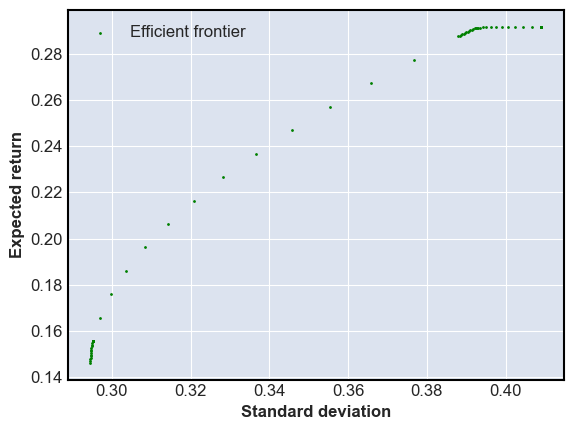

In [50]:
# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Efficient frontier')
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.legend()
plt.show()

### Efficient frontier in division per epochs

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23288\3731416365.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


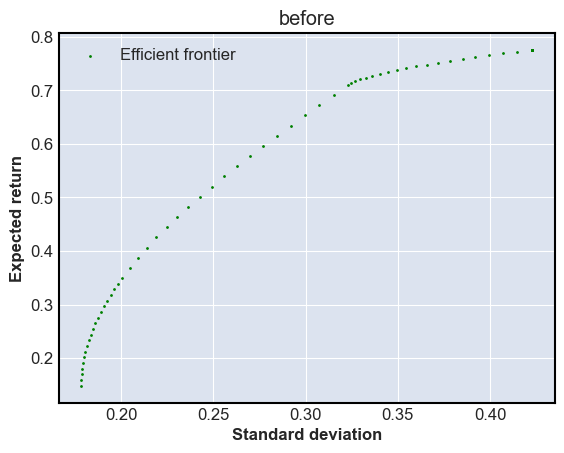

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23288\3731416365.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


OrderedDict([('AAPLUS', 0.10920059029892806), ('MSFTUS', 0.7185241287297404), ('AMZNUS', 0.11532208016649173), ('NVDAUS', 0.05695320080483972)])


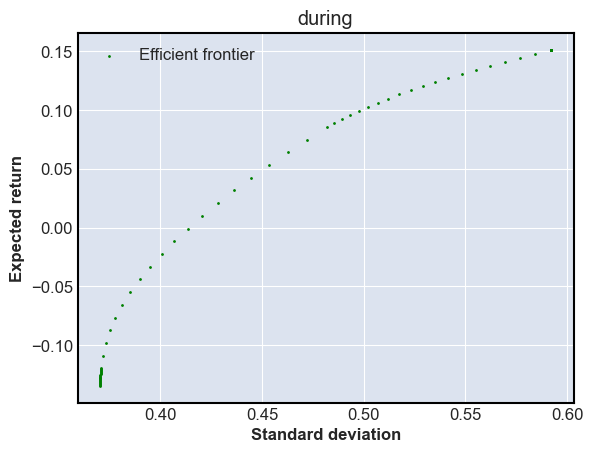

OrderedDict([('AAPLUS', 0.22422283692667058), ('MSFTUS', 0.7052240619326882), ('AMZNUS', 0.05173600914676272), ('NVDAUS', 0.01881709199387873)])


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1217: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = labels.slice_indexer(slice_obj.start, slice_obj.stop, slice_obj.step)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6407: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
C:\Users\tgusc\AppData\Local\Temp\ipykernel_23288\3731416365.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )


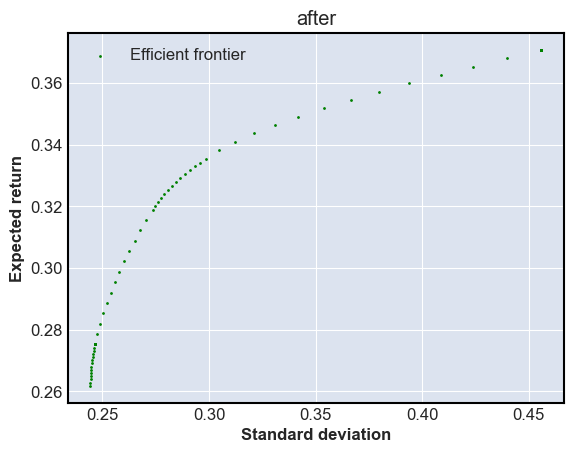

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OrderedDict([('AAPLUS', 0.3629663199697209), ('MSFTUS', 0.49848819651428133), ('AMZNUS', 0.13854548351599774), ('NVDAUS', 0.0)])


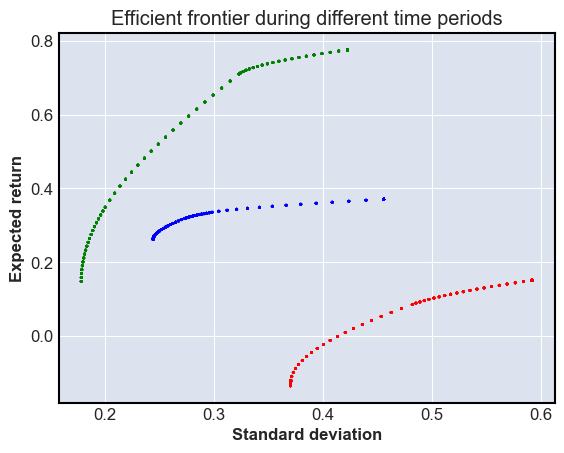

In [75]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1/1/2005', 'end': '31/12/2006'},
           'during' : {'start': '1/1/2007', 'end': '31/12/2008'},
           'after'  : {'start': '1/1/2009', 'end': '31/12/2022'}
         }

# Compute the efficient covariance for each epoch
mu_epoch = {}
e_cov_epoch = {}
efficient_portfolio_epoch = {}

for x in epochs.keys():
    sub_price = stocks.loc[epochs[x]['start']:epochs[x]['end']]
    mu_epoch[x] = expected_returns.mean_historical_return(sub_price)
    e_cov_epoch[x] = risk_models.CovarianceShrinkage(sub_price).ledoit_wolf()
    efficient_portfolio_epoch[x] = CLA(mu_epoch[x], e_cov_epoch[x])
    (ret, vol, weights) = efficient_portfolio_epoch[x].efficient_frontier()
    #2022/12/14 - fix this to work to populate empty dataframe
    frontier_new_data = pd.concat([pd.Series(ret), pd.Series(vol)], axis=1, keys=('returns','volume'))
    frontier_new_data["epoch"]=x
    Epoch_frontier = Epoch_frontier.append(frontier_new_data, ignore_index=True )
    
    plt.scatter(vol, ret, s = 4, c = 'g', marker = '.')
    plt.title(x)
    plt.legend(['Efficient frontier'])
    plt.xlabel('Standard deviation', fontsize=12)
    plt.ylabel('Expected return', fontsize=12)
    plt.show()
    print(efficient_portfolio_epoch[x].min_volatility())   

# Display the efficient covariance matrices for all epochs

colors = {'before':'green', 'during':'red', 'after':'blue'}


plt.scatter(Epoch_frontier["volume"], Epoch_frontier["returns"], s = 4, c = Epoch_frontier['epoch'].map(colors), marker = '.')
plt.title('Efficient frontier during different time periods')
#plt.legend(['Before', 'During', 'After'])
plt.legend(loc='lower right')
plt.xlabel('Standard deviation', fontsize=12)
plt.ylabel('Expected return', fontsize=12)
plt.show()

In [ ]:
print("Efficient Covariance Matrices\n", e_cov_epoch)

In [ ]:
print("Efficient Covariance Matrices\n", mu_epoch)

In [ ]:
print("Efficient portfolios\n", efficient_portfolio_epoch)

In [ ]:
### 2022-12-13 Add efficient frontier
(ret, vol, weights) = efficient_portfolio_epoch.efficient_frontier()